Dataset shape after processing: (12597, 118)


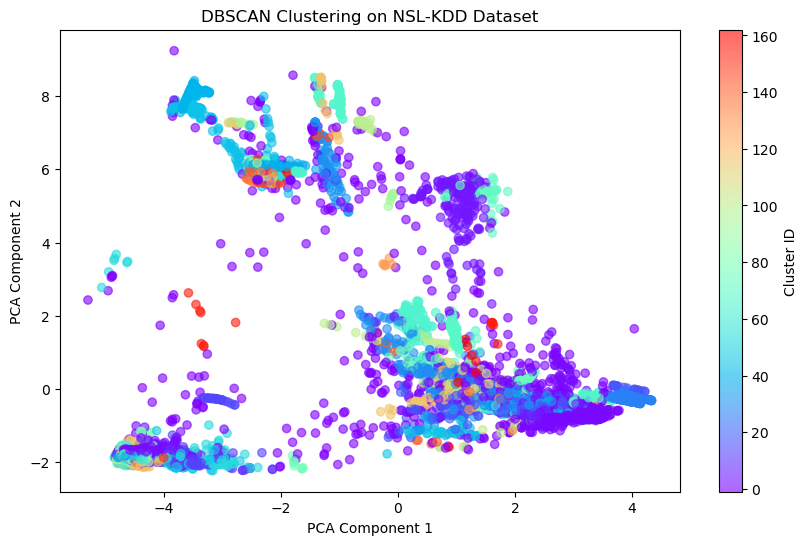

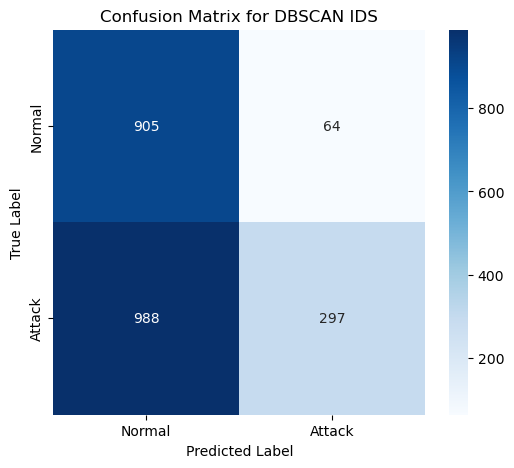

Accuracy: 0.5333
F1 Score: 0.4776
              precision    recall  f1-score   support

           0       0.48      0.93      0.63       969
           1       0.82      0.23      0.36      1285

    accuracy                           0.53      2254
   macro avg       0.65      0.58      0.50      2254
weighted avg       0.67      0.53      0.48      2254



In [3]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
import warnings
np.warnings = warnings

# Identify categorical features.
categorical_cols = ['protocol_type', 'service', 'flag']

df = pd.read_csv("../Dataset/KDDTrain+.txt", header=None, sep=',', engine='python')
test_df = pd.read_csv("../Dataset/KDDTest+.txt", header=None, sep=',', engine='python')

# Define all feature names based on NSL-KDD dataset
all_features = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_count',
    'dst_host_diff_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'target', 'difficulty'
]

df = df.sample(frac=0.1, replace=False)
test_df = test_df.sample(frac=0.1, replace=False)

df.columns = all_features
test_df.columns = all_features

df['target'] = df['target'].apply(lambda x: 1 if x != 'normal' else 0)
test_df['target'] = test_df['target'].apply(lambda x: 1 if x != 'normal' else 0)

# Drop 'difficulty' column (not needed for model training)
df.drop(columns=['difficulty'], inplace=True)
test_df.drop(columns=['difficulty'], inplace=True)

# One-Hot Encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_encoded = encoder.fit_transform(df[categorical_cols])
test_df_encoded = encoder.transform(test_df[categorical_cols])

# Convert encoded features into DataFrame
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
df_encoded = pd.DataFrame(df_encoded, columns=encoded_feature_names)
test_df_encoded = pd.DataFrame(test_df_encoded, columns=encoded_feature_names)

# Drop original categorical columns and concatenate encoded features
df = df.drop(columns=categorical_cols).reset_index(drop=True)
test_df = test_df.drop(columns=categorical_cols).reset_index(drop=True)
df = pd.concat([df, df_encoded], axis=1)
test_df = pd.concat([test_df, test_df_encoded], axis=1)

# Normalize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['target']))
test_df_scaled = scaler.transform(test_df.drop(columns=['target']))

print(f"Dataset shape after processing: {df_scaled.shape}")

# Apply PCA for visualization (reducing to 2D)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
test_df_pca = pca.transform(test_df_scaled)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=2, min_samples=5, metric='euclidean')
dbscan_labels = dbscan.fit_predict(df_scaled)

# Assign cluster labels to dataset
df['cluster'] = dbscan_labels

# Mark anomalies (-1 is DBSCAN's noise cluster, meaning outliers)
df['anomaly'] = (df['cluster'] == -1).astype(int)

# Plot Clusters and Anomalies
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['cluster'], cmap='rainbow', alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering on NSL-KDD Dataset")
plt.colorbar(scatter, label="Cluster ID")
plt.show()

# Map test set to clusters
test_clusters = dbscan.fit_predict(test_df_scaled)

# Assign predicted labels based on clustering
test_df['cluster'] = test_clusters
test_df['predicted_label'] = (test_df['cluster'] == -1).astype(int)  # -1 means anomaly

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(test_df['target'], test_df['predicted_label'])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for DBSCAN IDS")
plt.show()

# Compute Evaluation Metrics
accuracy = accuracy_score(test_df['target'], test_df['predicted_label'])
f1 = f1_score(test_df['target'], test_df['predicted_label'], average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(test_df['target'], test_df['predicted_label']))